In [47]:
from pathlib import Path
import pandas as pd
import numpy as np

ROOT = Path.cwd()
RESULTS = ROOT / 'results'
DATA = ROOT / 'data'

print('CWD:', ROOT)
print('results:', RESULTS.resolve() if RESULTS.exists() else 'MISSING')
if not RESULTS.exists():
    raise FileNotFoundError('Open this notebook from your project root (folder that contains results/).')

CWD: /Users/bist
results: /Users/bist/results


In [49]:
def load_metrics(name, model):
    p = RESULTS / name
    if not p.exists():
        raise FileNotFoundError(f'Missing metrics file: {p}')
    df = pd.read_csv(p)
    df['model'] = model
    return df

m_baseline = load_metrics('best_baseline_metrics_test.csv', 'Baseline (TFIDF+LinearSVC)')
m_cnn      = load_metrics('cnn_metrics_test.csv', 'CNN')
m_bert     = load_metrics('distilbert_metrics_test.csv', 'DistilBERT')

cmp = pd.concat([m_baseline, m_cnn, m_bert], ignore_index=True)
cols = ['model','accuracy','precision_spam','recall_spam','f1_spam','roc_auc']
cmp = cmp[cols].sort_values('f1_spam', ascending=False)

cmp.to_csv(RESULTS / 'final_comparison_test.csv', index=False)
cmp


,model,accuracy,precision_spam,recall_spam,f1_spam,roc_auc
2,DistilBERT,0.992268,0.989362,0.948980,0.968750,0.997336
0,Baseline (TFIDF+LinearSVC),0.987113,0.978261,0.918367,0.947368,0.992550
1,CNN,0.972938,0.846847,0.959184,0.899522,0.991993


In [51]:
def load_texts(csv_name):
    p = RESULTS / csv_name
    if not p.exists():
        print('Missing:', csv_name)
        return []
    df = pd.read_csv(p)
    if 'text' in df.columns:
        return df['text'].astype(str).tolist()
    return df.iloc[:,0].astype(str).tolist()

def show_some(title, items, k=5):
    print(f"{title}: {len(items)}")
    for i,t in enumerate(items[:k],1):
        print(f"  [{i}] {t}")

fp_base = load_texts('baseline_false_positives.csv')
fn_base = load_texts('baseline_false_negatives.csv')
fp_cnn  = load_texts('cnn_false_positives.csv')
fn_cnn  = load_texts('cnn_false_negatives.csv')
fp_bert = load_texts('distilbert_false_positives.csv')
fn_bert = load_texts('distilbert_false_negatives.csv')

print('=== BASELINE ===')
show_some('False Positives (ham→spam)', fp_base)
show_some('False Negatives (spam→ham)', fn_base)

print('=== CNN ===')
show_some('False Positives (ham→spam)', fp_cnn)
show_some('False Negatives (spam→ham)', fn_cnn)

print('=== DISTILBERT ===')
show_some('False Positives (ham→spam)', fp_bert)
show_some('False Negatives (spam→ham)', fn_bert)


=== BASELINE ===
False Positives (ham→spam): 2
  [1] Please protect yourself from e-threats. SIB never asks for sensitive information like Passwords,ATM/SMS PIN thru email. Never share your password with anybody.

  [2] Your daily text from me – a favour this time

False Negatives (spam→ham): 8
  [1] Would you like to see my XXX pics they are so hot they were nearly banned in the uk!

  [2] Burger King - Wanna play footy at a top stadium? Get 2 Burger King before 1st Sept and go Large or Super with Coca-Cola and walk out a winner

  [3] Latest News! Police station toilet stolen, cops have nothing to go on!

  [4] Hi its LUCY Hubby at meetins all day Fri & I will B alone at hotel U fancy cumin over? Pls leave msg 2day 09099726395 Lucy x Calls£1/minMobsmoreLKPOBOX177HP51FL

  [5] Want explicit SEX in 30 secs? Ring 02073162414 now! Costs 20p/min

=== CNN ===
False Positives (ham→spam): 17
  [1] "Hello-/@drivby-:0quit edrunk sorry iff pthis makes no senrd-dnot no how ^ dancce 2 drum n basq

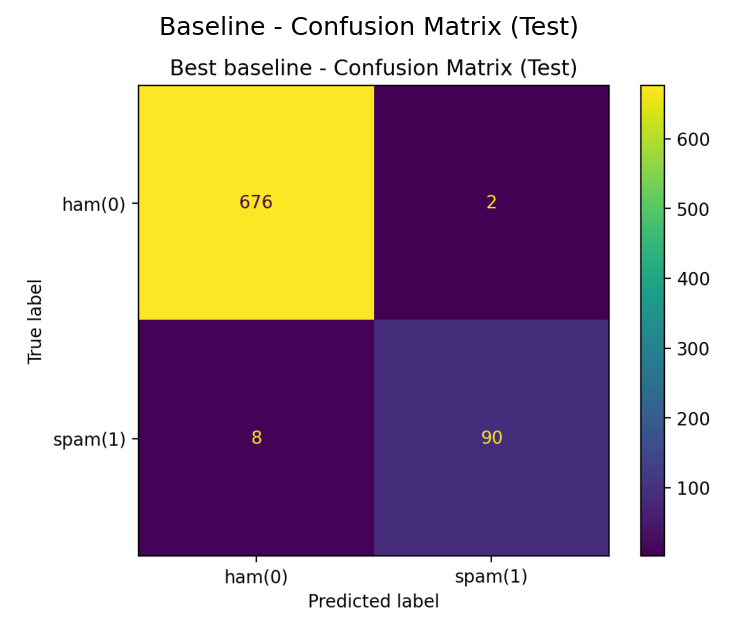

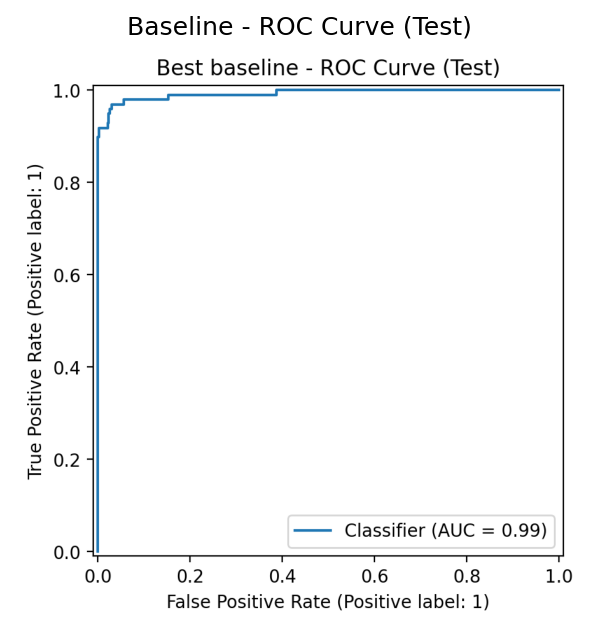

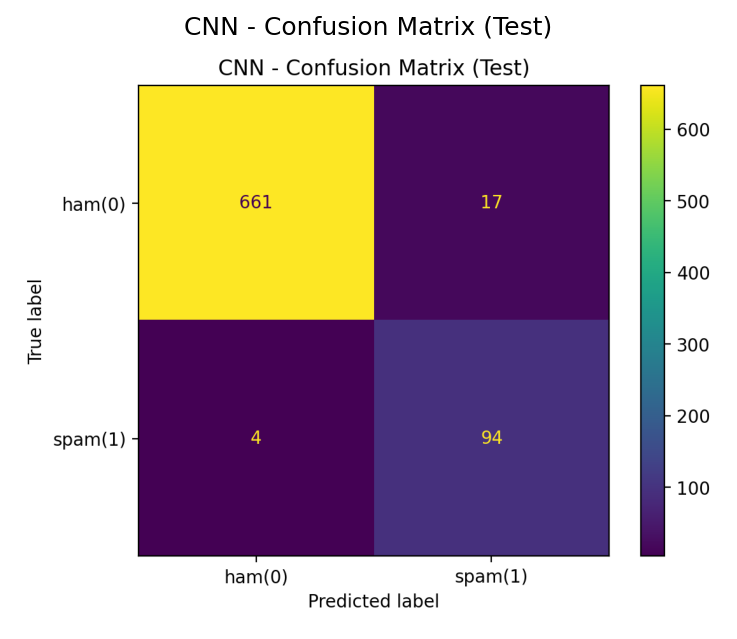

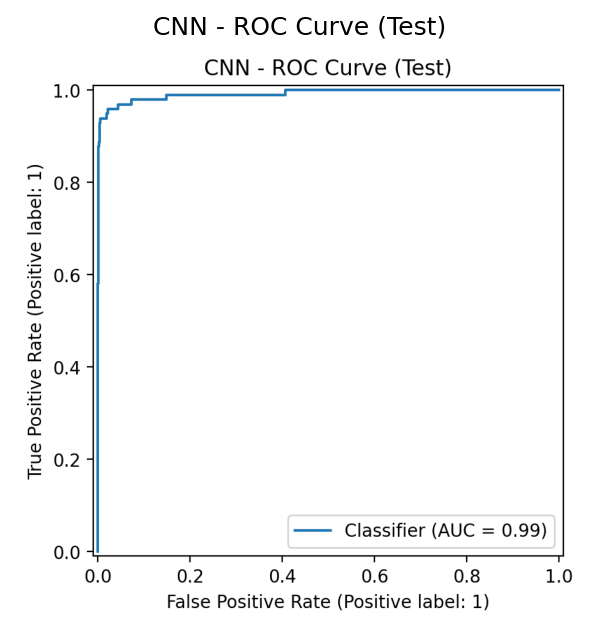

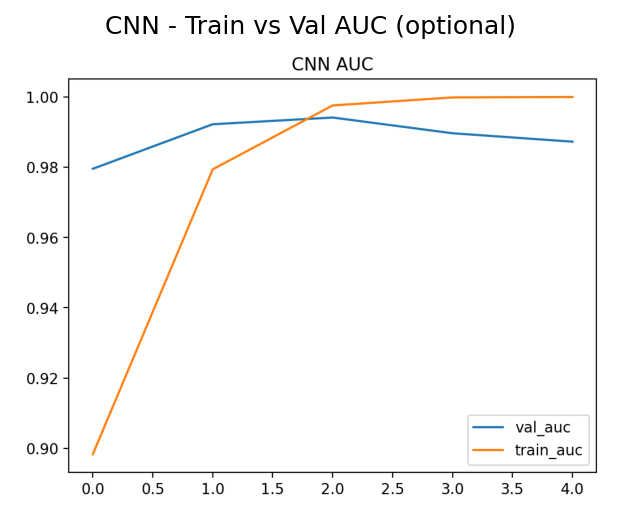

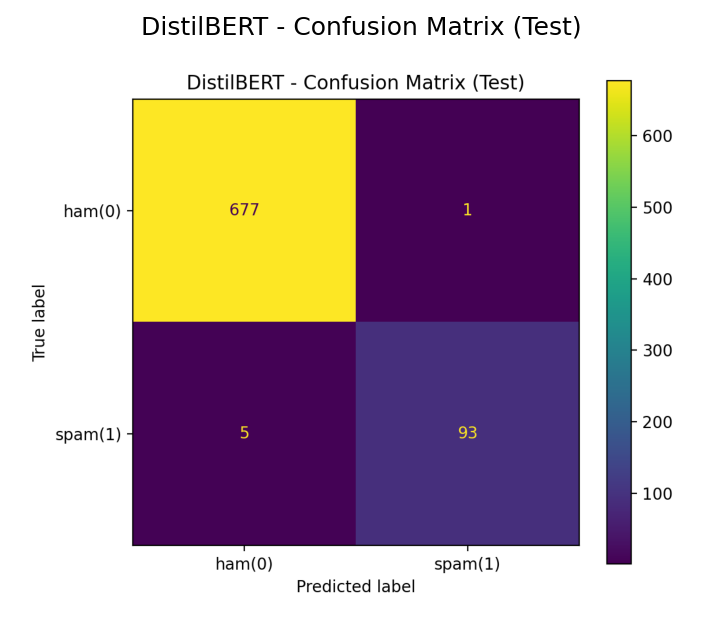

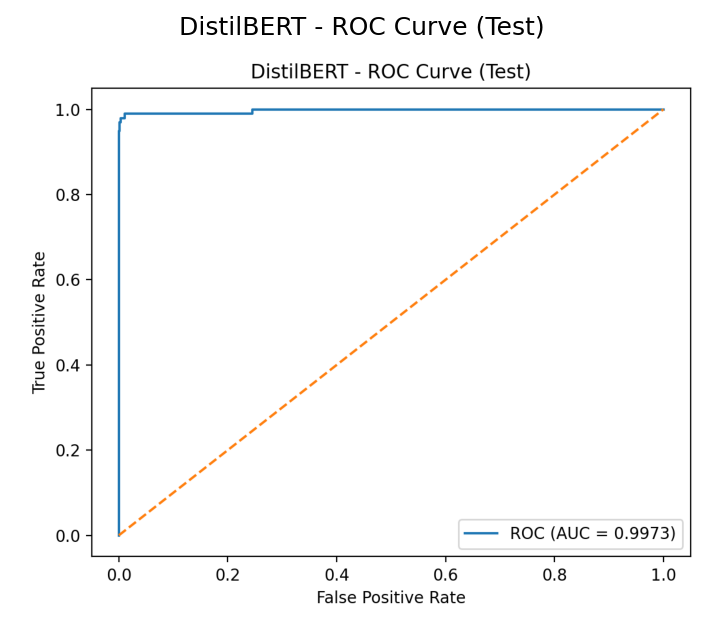

In [53]:
from PIL import Image
import matplotlib.pyplot as plt

def show_img(fname, title=None, figsize=(7,5)):
    p = RESULTS / fname
    if not p.exists():
        print('Missing image:', fname)
        return
    img = Image.open(p)
    plt.figure(figsize=figsize, dpi=150)
    plt.imshow(img)
    plt.axis('off')
    plt.title(title or fname)
    plt.show()

show_img('best_baseline_confusion_matrix.png', 'Baseline - Confusion Matrix (Test)')
show_img('best_baseline_roc_curve.png', 'Baseline - ROC Curve (Test)')

show_img('cnn_confusion_matrix.png', 'CNN - Confusion Matrix (Test)')
show_img('cnn_roc_curve.png', 'CNN - ROC Curve (Test)')
show_img('cnn_learning_auc.png', 'CNN - Train vs Val AUC (optional)', figsize=(7,4))

show_img('distilbert_confusion_matrix.png', 'DistilBERT - Confusion Matrix (Test)')
show_img('distilbert_roc_curve.png', 'DistilBERT - ROC Curve (Test)')


In [55]:
from pathlib import Path
import numpy as np
from lime.lime_text import LimeTextExplainer

RESULTS = Path("results")
RESULTS.mkdir(exist_ok=True)

explainer = LimeTextExplainer(class_names=["ham","spam"])

def load_text_list(csv_path):
    p = RESULTS / csv_path
    if not p.exists():
        return []
    import pandas as pd
    df = pd.read_csv(p)
    if "text" in df.columns:
        return df["text"].astype(str).tolist()
    return df.iloc[:,0].astype(str).tolist()

def pick_sample(fp_list, fn_list):
    # Prefer FN (missed spam) for a better “story”
    if fn_list:
        return fn_list[0]
    if fp_list:
        return fp_list[0]
    return None

In [57]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

# Load splits + dataset (για να εκπαιδεύσεις baseline reproducibly)
df = pd.read_csv("data/sms_clean.csv")[["text","label"]]
splits = np.load("data/split_idx.npz")
train_idx = splits["train_idx"]

X_train = df.iloc[train_idx]["text"].astype(str).values
y_train = df.iloc[train_idx]["label"].astype(int).values

# Train baseline (ή φόρτωσε αν το έχεις ήδη)
baseline = Pipeline([
    ("tfidf", TfidfVectorizer(lowercase=True, ngram_range=(1,2), min_df=2)),
    ("clf", LinearSVC(class_weight="balanced"))
])
baseline.fit(X_train, y_train)

# Choose an error example from baseline FP/FN lists (saved in results/)
baseline_fp = load_text_list("baseline_false_positives.csv")
baseline_fn = load_text_list("baseline_false_negatives.csv")
sample_text = pick_sample(baseline_fp, baseline_fn) or X_train[0]

# LIME needs probabilities → approximate from decision_function
def baseline_predict_proba(texts):
    scores = baseline.decision_function(list(texts))
    probs_spam = 1 / (1 + np.exp(-scores))
    probs_ham = 1 - probs_spam
    return np.vstack([probs_ham, probs_spam]).T

exp = explainer.explain_instance(
    sample_text[:300],
    baseline_predict_proba,
    num_features=8,
    num_samples=800
)

(RESULTS / "lime_baseline.html").write_text(exp.as_html(), encoding="utf-8")
print("Saved -> results/lime_baseline.html")
print("Explained text:\n", sample_text)

Saved -> results/lime_baseline.html
Explained text:
 Would you like to see my XXX pics they are so hot they were nearly banned in the uk!



In [63]:
import pandas as pd
from pathlib import Path

RESULTS = Path("results")

def load_texts(fname):
    p = RESULTS / fname
    if not p.exists():
        print("Missing:", fname)
        return []
    df = pd.read_csv(p)
    if "text" in df.columns:
        return df["text"].astype(str).tolist()
    return df.iloc[:,0].astype(str).tolist()

def show_samples(title, texts, n=5):
    print(f"\n{title} (count={len(texts)})")
    for i, t in enumerate(texts[:n], 1):
        t = t.replace("\n"," ").strip()
        print(f"  [{i}] {t}")

# CNN
cnn_fp = load_texts("cnn_false_positives.csv")
cnn_fn = load_texts("cnn_false_negatives.csv")

# DistilBERT
bert_fp = load_texts("distilbert_false_positives.csv")
bert_fn = load_texts("distilbert_false_negatives.csv")

print("=== CNN ===")
show_samples("CNN False Positives (ham→spam)", cnn_fp, n=5)
show_samples("CNN False Negatives (spam→ham)", cnn_fn, n=5)

print("\n=== DistilBERT ===")
show_samples("DistilBERT False Positives (ham→spam)", bert_fp, n=5)
show_samples("DistilBERT False Negatives (spam→ham)", bert_fn, n=5)

=== CNN ===

CNN False Positives (ham→spam) (count=17)
  [1] "Hello-/@drivby-:0quit edrunk sorry iff pthis makes no senrd-dnot no how ^ dancce 2 drum n basq!ihave fun 2nhite x ros xxxxxxx"
  [2] No got new job at bar in airport on satsgettin 4.47per hour but means no lie in! keep in touch
  [3] Have you laid your airtel line to rest?
  [4] Are we doing the norm tomorrow? I finish just a 4.15 cos of st tests. Need to sort library stuff out at some point tomo - got letter from today - access til end march so i better get move on!
  [5] How to Make a girl Happy? It's not at all difficult to make girls happy. U only need to be... 1. A friend 2. Companion 3. Lover 4. Chef . . .  &lt;#&gt; . Good listener  &lt;#&gt; . Organizer  &lt;#&gt; . Good boyfriend  &lt;#&gt; . Very clean  &lt;#&gt; . Sympathetic  &lt;#&gt; . Athletic  &lt;#&gt; . Warm . . .  &lt;#&gt; . Courageous  &lt;#&gt; . Determined  &lt;#&gt; . True  &lt;#&gt; . Dependable  &lt;#&gt; . Intelligent . . .  &lt;#&gt; . Psychologis

In [65]:
import re
import pandas as pd

def pattern_features(text):
    t = str(text)
    return {
        "has_url": bool(re.search(r"(http|www\.)", t.lower())),
        "has_phone": bool(re.search(r"\b\d{10,}\b", re.sub(r"\D","",t))),  # crude
        "has_money": bool(re.search(r"[$€£]|\b(eur|usd|gbp)\b", t.lower())),
        "has_digits": any(ch.isdigit() for ch in t),
        "many_exclaim": t.count("!") >= 2,
        "allcaps_word": bool(re.search(r"\b[A-Z]{4,}\b", t)),
        "has_free_win": bool(re.search(r"\b(free|win|winner|prize|claim)\b", t.lower())),
        "has_urgent": bool(re.search(r"\b(urgent|now|today|asap|immediately)\b", t.lower())),
    }

def summarize_patterns(texts, name):
    if not texts:
        print(f"\n{name}: no texts")
        return
    dfp = pd.DataFrame([pattern_features(t) for t in texts])
    rates = dfp.mean().sort_values(ascending=False)
    print(f"\n{name} (n={len(texts)}) pattern rates:")
    display(rates.to_frame("rate"))

summarize_patterns(cnn_fp, "CNN FP")
summarize_patterns(cnn_fn, "CNN FN")
summarize_patterns(bert_fp, "DistilBERT FP")
summarize_patterns(bert_fn, "DistilBERT FN")


CNN FP (n=17) pattern rates:


,rate
has_digits,0.647059
allcaps_word,0.117647
has_money,0.058824
many_exclaim,0.058824
has_free_win,0.058824
has_urgent,0.058824
has_url,0.000000
has_phone,0.000000



CNN FN (n=4) pattern rates:


,rate
many_exclaim,0.50
has_digits,0.25
allcaps_word,0.25
has_url,0.00
has_phone,0.00
has_money,0.00
has_free_win,0.00
has_urgent,0.00



DistilBERT FP (n=1) pattern rates:


,rate
has_url,0.0
has_phone,0.0
has_money,0.0
has_digits,0.0
many_exclaim,0.0
allcaps_word,0.0
has_free_win,0.0
has_urgent,0.0



DistilBERT FN (n=5) pattern rates:


,rate
has_digits,0.4
many_exclaim,0.2
allcaps_word,0.2
has_free_win,0.2
has_url,0.0
has_phone,0.0
has_money,0.0
has_urgent,0.0
